In [29]:
import torch
import torch.nn.functional as F
import numpy
import matplotlib.pyplot as plt


import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

# Load data for training

In [30]:
import os
import urllib
# Ensure to upload these files to colab before running
from model_components_all import create_loader, GPTModel
from config import GPT_CONFIG_124M

context_len = GPT_CONFIG_124M["context_len"]
stride  = context_len
batch_size = 2

if not os.path.exists('verdict.txt'):
  url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/refs/heads/main/ch02/01_main-chapter-code/the-verdict.txt"
  file_path = "sample_data/verdict.txt"
  urllib.request.urlretrieve(url,file_path)

with open('./sample_data/verdict.txt','r',encoding='utf8') as Fd:
  raw_data = Fd.read()




In [31]:
len(raw_data)

20479

In [32]:
# Partition train & eval data 90% and 10% respectively
train_ix = int(0.9*len(raw_data))
train_data = raw_data[:train_ix]
eval_data = raw_data[train_ix:]

#Training Set (90%)
train_data,tkn = create_loader(raw_data, batch_size=batch_size,
                                context_len=context_len,
                                stride=stride,
                                num_workers=0, shuffle=True)

#Validation Set (90%)
eval_data,tkn = create_loader(raw_data, batch_size=batch_size,
                                context_len=context_len,
                                stride=stride,
                                num_workers=0, shuffle=True)

batch_size=2,context_len=1024, stride=1024,shuffle=True,  num_workers=0
batch_size=2,context_len=1024, stride=1024,shuffle=True,  num_workers=0


In [33]:
for train_i, target_i in train_data:
  print(train_i.shape)

torch.Size([2, 1024])
torch.Size([2, 1024])


In [34]:
# Helper function for inference
def infer_text(sample_txt, model, device):

  #enc = tokenizer.encode(sample_txt)
  enc = tokenizer.encode(sample_txt, allowed_special={'<|endoftext|>'})
  enc_tensor = torch.tensor(enc).unsqueeze(0)

  # Context length is defined above.
  outt = decode_text(model,enc_tensor,50,device=device)
  lst = outt.squeeze(0).tolist()
  txt = tokenizer.decode(lst)
  print(txt.replace("\n", " "))

#Pretraining
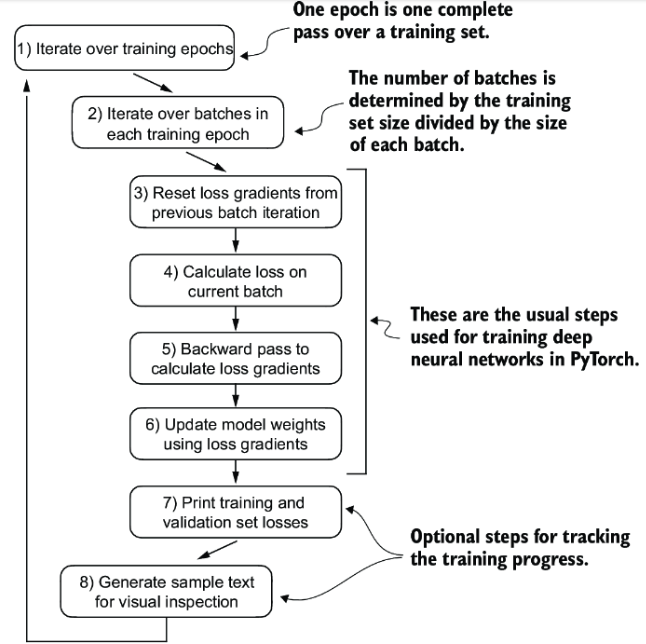

In [35]:
def decode_text(model, idx, num_samples, device):

  idx = idx.to(device)
  model.eval()
  ctx_len = model.pos_emb.weight.shape[0]

  for _ in range(num_samples):
    idx_curr = idx[:,-ctx_len:].to(device)
    with torch.no_grad():
        logits= model(idx_curr.to(device))
    idx_pred = logits[:,-1,:].to(device)
    #Extract the position index of the largest logits
    pred_tok = torch.argmax(idx_pred.to(device), dim=-1, keepdim=True).to(device)

    #print(tokenizer.decode(idx.squeeze(0).tolist()).replace('\n', " "))
    idx= torch.cat((idx,pred_tok),dim=1).to(device)

  model.train()
  return idx

In [36]:
# Helper function to calculate loss
def calc_loss_batch(x_batch, target_batch, model, device):

  #Move to gpu if available
  x_batch, target_batch = x_batch.to(device), target_batch.to(device)
  logits = model(x_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0,1),target_batch.flatten())

  return loss


In [37]:

  for x_data,y_data in eval_data:
    print(x_data.shape,y_data.shape)

  for x_data,y_data in train_data:
    print(x_data.shape,y_data.shape)

torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])
torch.Size([2, 1024]) torch.Size([2, 1024])


In [38]:
# Local Test to see if train and validate losses functions work.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)  # Outputs 'cuda' or 'cpu'

model = GPTModel(cfg=GPT_CONFIG_124M)
model.to(device)
optimizer= torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.1)

train_loss =[]
eval_loss = []
with torch.no_grad():
  train_loss.append( [calc_loss_batch(x_data, y_data, model, device).item() for x_data,y_data in train_data])
  eval_loss.append( [calc_loss_batch(x_data, y_data, model, device).item() for x_data,y_data in eval_data])

train_loss = sum(train_loss[0])/len(train_loss[0])
eval_loss = sum(eval_loss[0])/len(eval_loss[0])
print(f"{train_loss=}")
print(f"{eval_loss=}")



cuda
train_loss=10.980364322662354
eval_loss=10.980364322662354


In [39]:
def pretrain_llm(n_epochs, model, train_data, eval_data, optimizer  ,device):

  loss_vec , epoch_vec, batch_vec =[], [],[]
  ix = 0
  for epoch in range(n_epochs):
    # Set in training mode
    model.train()

    for x_batch , target_batch in train_data:
      #print(f"{epoch=}",{x_batch.shape},{target_batch.shape})
      optimizer.zero_grad()
      loss = calc_loss_batch(x_batch,target_batch,model,device)
      #Backpropagation - to caculate loss gradients
      loss.backward()
      #update weights
      optimizer.step()
      #store the loss for analysis
      loss_vec.append(loss.log10().item())
      batch_vec.append(ix)
      ix +=1
      #print(f"{loss.item()=}")

    infer_text("What is the name of the king who ", model, device) if epoch%50==0 else ...
    print(f"{epoch}:{loss.item()=}") if epoch%10==0 else ...
    epoch_vec.append(epoch)
  infer_text("What is the name of the king who ", model, device)
  return loss_vec, loss, epoch_vec, batch_vec

In [40]:
# Calculate validation loss to assess potential overfitting.
def validate_llm(eval_data, model, device):
  eval_loss_i = []
  model.eval()
  with torch.no_grad():
    eval_loss_i.append( [calc_loss_batch(x_data, y_data, model, device).item() for x_data,y_data in eval_data])

  eval_loss = sum(eval_loss_i[0])/len(eval_loss_i[0])
  print(f"{eval_loss=}")
  return eval_loss_i, eval_loss

In [41]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)  # Outputs 'cuda' or 'cpu'


model = GPTModel(cfg=GPT_CONFIG_124M)
model.to(device)
optimizer= torch.optim.AdamW(model.parameters(), lr=0.00001, weight_decay=0.1)

cuda


In [50]:
n_epochs = 100
loss_i, loss, epoch_i, batch_i = pretrain_llm(n_epochs, model, train_data, eval_data, optimizer  ,device)
print("--------")
print(f"{loss=}")
print(loss_i,loss,epoch_i)
eval_loss_i, eval_loss = validate_llm(eval_data, model, device)
print("--------")
print(f"{eval_loss=}")


What is the name of the king who , and I had, I had of the the--I to the, I had.    ".                  " to the.    
0:loss.item()=5.802945613861084
10:loss.item()=5.563754081726074
20:loss.item()=5.079183101654053
30:loss.item()=4.873144149780273
40:loss.item()=4.5132904052734375
What is the name of the king who , his his of the, I had the picture--I to the--, and. Gisburn's " the, and I had been, and.   " the, the, and.       "
50:loss.item()=4.232503890991211
60:loss.item()=3.8807778358459473
70:loss.item()=3.692877769470215
80:loss.item()=3.359157085418701
90:loss.item()=3.003964900970459
What is the name of the king who ,-I of the him. "--I of to the--, and. Gisburn's " the was had been--and to to me, to have been the a--I. " to--. Stroud. 
--------
loss=tensor(2.8360, device='cuda:0', grad_fn=<NllLossBackward0>)
[0.7881695032119751, 0.763648509979248, 0.781501054763794, 0.774146556854248, 0.7668044567108154, 0.7703394889831543, 0.7688579559326172, 0.7676143050193787, 0.767706036

Text(0, 0.5, 'loss in log10')

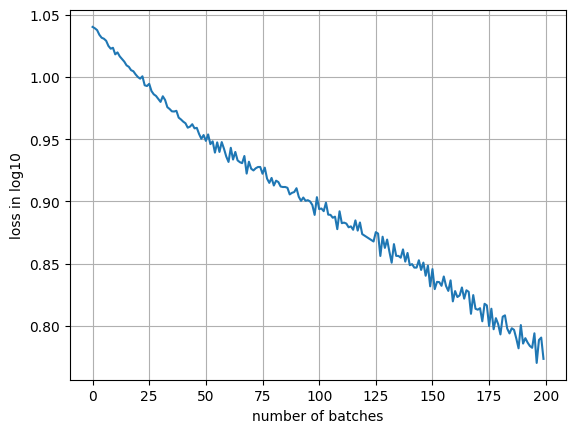

In [48]:
plt.plot(range(len(loss_i)), loss_i)
plt.grid(True)
plt.xlabel("number of batches")
plt.ylabel("loss in log10")

In [49]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

sample_txt = "Ai has transformed the world "
sample_txt2 = "This is the result of our own "

#def infer_text(sample_txt2, model, context_len,device):
enc = tokenizer.encode(sample_txt)
#print(f"{len(enc)=}")
enc_tensor = torch.tensor(enc).unsqueeze(0).to(device)
#print(f"{enc_tensor.shape=}")

# Context length is defined above.
outt = decode_text(model,enc_tensor,50,device=device)
lst = outt.squeeze(0).tolist()
print(tokenizer.decode(lst).replace('\n', ""))

Ai has transformed the world ."--", I had, and, and I had, I had of the, and I was the was, and, and I had the, I was the the the picture, and.
